In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autotime

import scarf
scarf.__version__

'0.7.2'

time: 798 ms


In [2]:
scarf.fetch_dataset('kang_15K_pbmc_rnaseq', save_path='scarf_datasets')
scarf.fetch_dataset('kang_14K_ifnb-pbmc_rnaseq', save_path='scarf_datasets')

INFO: Download started...
INFO: Download finished! File saved here: scarf_datasets/kang_15K_pbmc_rnaseq/barcodes.tsv.gz
INFO: Download started...
INFO: Download finished! File saved here: scarf_datasets/kang_15K_pbmc_rnaseq/matrix.mtx.gz
INFO: Download started...
INFO: Download finished! File saved here: scarf_datasets/kang_15K_pbmc_rnaseq/features.tsv.gz
INFO: Download started...
INFO: Download finished! File saved here: scarf_datasets/kang_14K_ifnb-pbmc_rnaseq/features.tsv.gz
INFO: Download started...
INFO: Download finished! File saved here: scarf_datasets/kang_14K_ifnb-pbmc_rnaseq/matrix.mtx.gz
INFO: Download started...
INFO: Download finished! File saved here: scarf_datasets/kang_14K_ifnb-pbmc_rnaseq/barcodes.tsv.gz
time: 10.1 s


In [3]:
def scarf_pipeline(in_dir=None, zarr_fn=None, pca_cell_key='I',
                   umap_label='UMAP', feat_key='hvgs', n_cluster=20):
    if in_dir is not None:
        zarr_fn = in_dir + '/data.zarr'
        reader = scarf.CrDirReader(in_dir, 'rna')
        scarf.CrToZarr(reader, zarr_fn=zarr_fn, chunk_size=(2000, 2000)).dump(batch_size=4000)
    if zarr_fn is None:
        raise ValueError("Please provide a Zarr file")
    ds = scarf.DataStore(zarr_fn, nthreads=8)
    ds.filter_cells(attrs=['RNA_nCounts', 'RNA_nFeatures', 'RNA_percentMito'], highs=[6000, 1500, 1], lows=[500, 100, 0])
    ds.filter_cells(attrs=['RNA_nCounts'], highs=[None], lows=[1000])
    ds.mark_hvgs(min_cells=10, top_n=2000)
    ds.make_graph(feat_key=feat_key, k=11, dims=25, n_centroids=100,
                  log_transform=True, renormalize_subset=True, pca_cell_key=pca_cell_key)
    ds.run_leiden_clustering(resolution=2)
    ds.run_umap(fit_n_epochs=250, min_dist=0.5, label=umap_label)
    return ds

time: 1.14 ms


100%|██████████| 4/4 [00:04<00:00,  1.00s/it]

INFO: Setting assay RNA to assay type: RNAassay
INFO: (RNA) Computing nCells and dropOuts
[##                                      ] | 7% Completed |  0.1s

[########################################] | 100% Completed |  0.5s
INFO: (RNA) Computing nCounts
[########################################] | 100% Completed |  0.5s
INFO: (RNA) Computing nFeatures
[########################################] | 100% Completed |  0.5s
INFO: Computing percentage of RNA_percentMito
[########################################] | 100% Completed |  0.4s
INFO: Computing percentage of RNA_percentRibo
[########################################] | 100% Completed |  0.4s
INFO: 37 cells flagged for filtering out using attribute RNA_nCounts
INFO: 152 cells flagged for filtering out using attribute RNA_nFeatures
INFO: 3436 cells flagged for filtering out using attribute RNA_percentMito
INFO: 4215 cells flagged for filtering out using attribute RNA_nCounts
INFO: (RNA) Computing nCells
[########################################] | 100% Completed |  0.6s
INFO: (RNA) Computing normed_tot
[########################################] | 100% Completed |  0.6s
INFO: (RNA) Computing

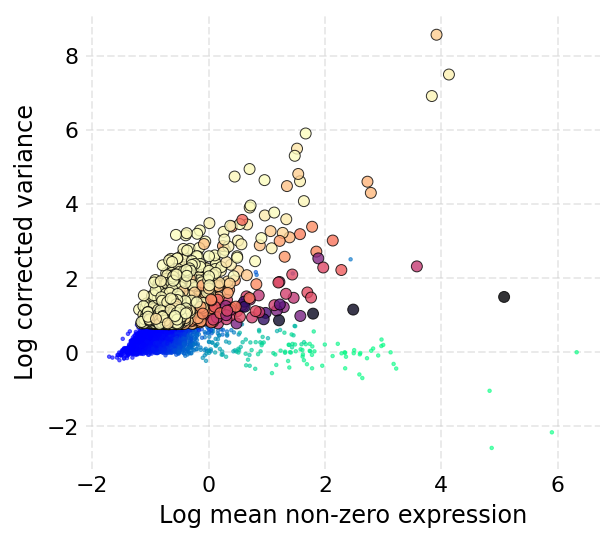

INFO: Using PCA for dimension reduction
INFO: No value provided for parameter `ann_metric`. Will use default value: l2
INFO: No value provided for parameter `ann_efc`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_ef`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_m`. Will use default value: 48
INFO: No value provided for parameter `rand_state`. Will use default value: 4466
INFO: No value provided for parameter `local_connectivity`. Will use default value: 1.0
INFO: No value provided for parameter `bandwidth`. Will use default value: 1.5
INFO: Normalizing with feature subset
[########################################] | 100% Completed |  0.4s


Writing data to normed__I__hvgs/data: 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]

INFO: Calculating mean of norm. data
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.1s
INFO: Calculating std. dev. of norm. data
[########################################] | 100% Completed |  0.1s


Estimating seed partitions: 100%|██████████| 5/5 [00:00<00:00,  7.66it/s]

INFO: Saving loadings to RNA/normed__I__hvgs/reduction__pca__25__I
INFO: Saving ANN index to RNA/normed__I__hvgs/reduction__pca__25__I/ann__l2__50__50__48__4466
INFO: Saving kmeans clusters to RNA/normed__I__hvgs/reduction__pca__25__I/kmeans__100__4466



Saving KNN graph: 100%|██████████| 5/5 [00:00<00:00,  6.87it/s]

INFO: ANN recall: 99.92%



Smoothening KNN distances: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


	completed  0  /  250 epochs
	completed  25  /  250 epochs
	completed  50  /  250 epochs
	completed  75  /  250 epochs
	completed  100  /  250 epochs
	completed  125  /  250 epochs
	completed  150  /  250 epochs
	completed  175  /  250 epochs
	completed  200  /  250 epochs
	completed  225  /  250 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
time: 48.1 s


In [4]:
# Control PBMC data
ds_ctrl = scarf_pipeline(in_dir='scarf_datasets/kang_15K_pbmc_rnaseq')

Finding markers: 100%|██████████| 227/227 [00:22<00:00, 10.29it/s]


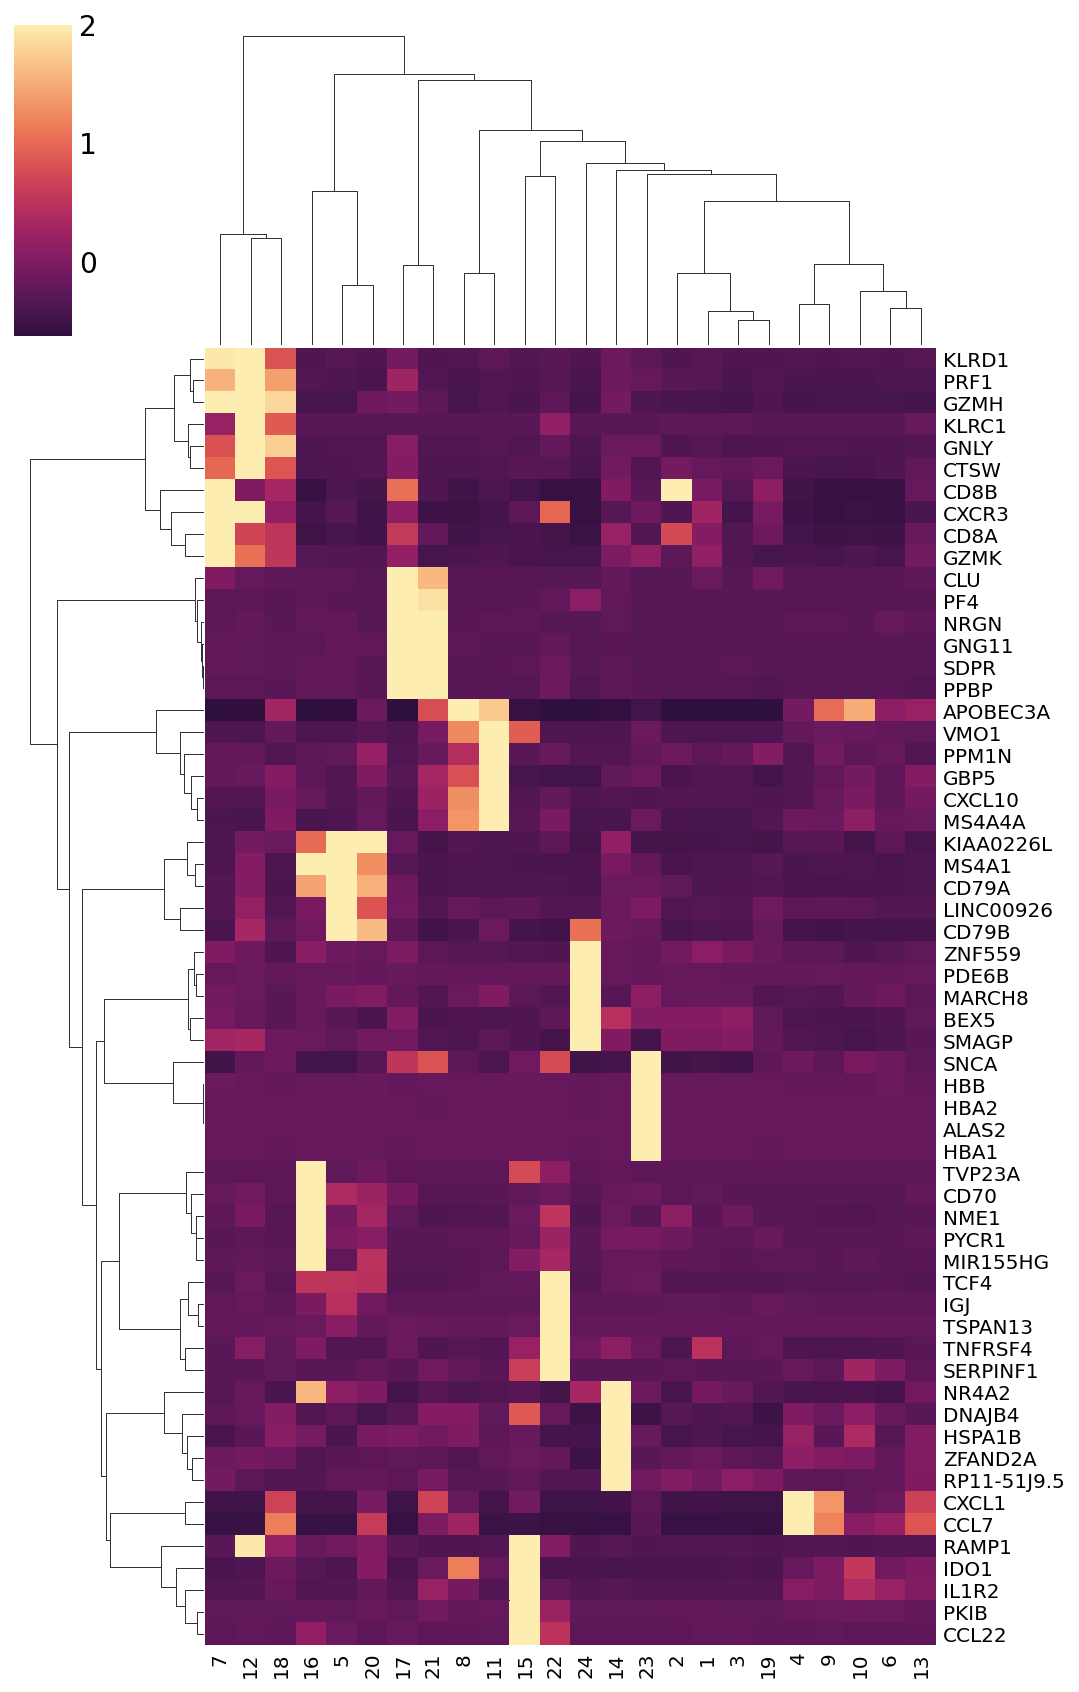

time: 24.5 s


In [5]:
ds_ctrl.run_marker_search(group_key='RNA_leiden_cluster')
ds_ctrl.plot_marker_heatmap(group_key='RNA_leiden_cluster', topn=5, figsize=(8,12))

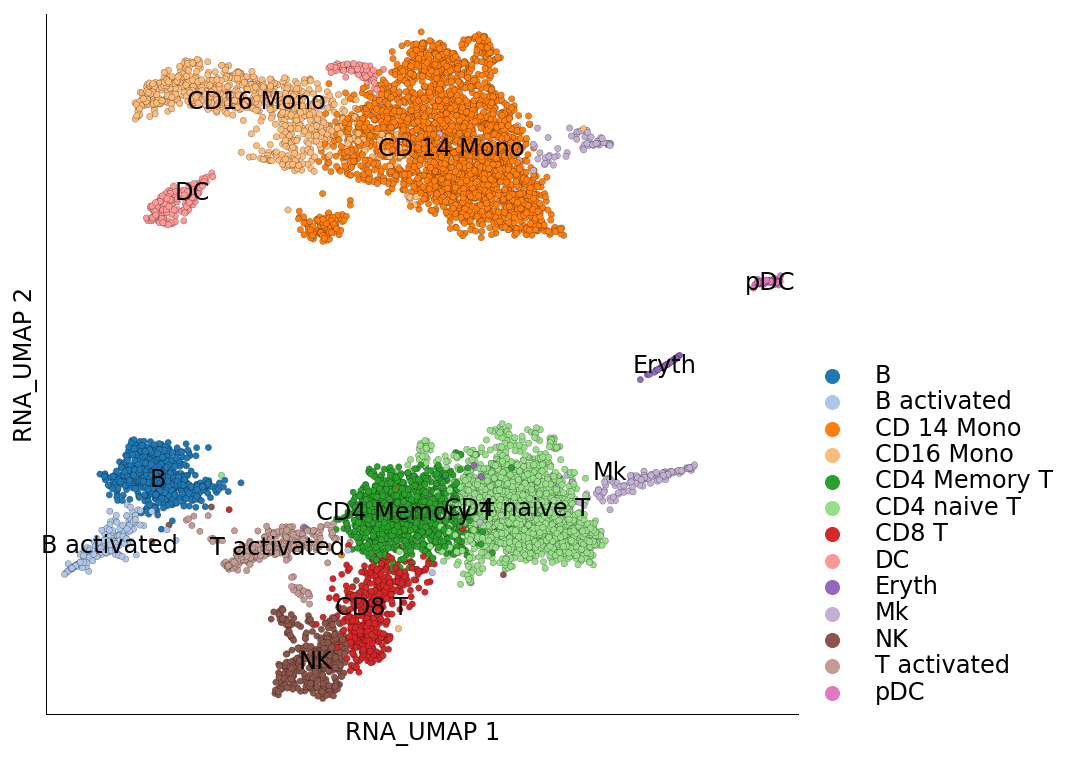

time: 562 ms


In [6]:
ctrl_cluster_labels = {
    19: 'CD4 naive T', 3: 'CD4 naive T', 2: 'CD4 naive T', 24: 'CD4 naive T',
    1: 'CD4 Memory T', 14: 'T activated', 7: 'CD8 T', 12: 'NK',
    5: 'B', 16: 'B activated', 11: 'CD16 Mono', 8: 'CD16 Mono',
    10: 'CD 14 Mono', 13: 'CD 14 Mono', 20: 'CD 14 Mono', 6: 'CD 14 Mono',
    9: 'CD 14 Mono', 4: 'CD 14 Mono', 18: 'CD 14 Mono',
    15: 'DC', 22: 'pDC', 17: 'Mk', 21: 'Mk', 23: 'Eryth'
}
ds_ctrl.cells.insert('cluster_labels',
                     [ctrl_cluster_labels[x] for x in ds_ctrl.cells.fetch('RNA_leiden_cluster')],
                     overwrite=True)
ds_ctrl.plot_layout(layout_key='RNA_UMAP', color_by='cluster_labels',
                    save_dpi=300)

100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

INFO: Setting assay RNA to assay type: RNAassay
INFO: (RNA) Computing nCells and dropOuts
[###                                     ] | 8% Completed |  0.1s

[########################################] | 100% Completed |  0.5s
INFO: (RNA) Computing nCounts
[########################################] | 100% Completed |  0.5s
INFO: (RNA) Computing nFeatures
[########################################] | 100% Completed |  0.5s
INFO: Computing percentage of RNA_percentMito
[########################################] | 100% Completed |  0.4s
INFO: Computing percentage of RNA_percentRibo
[########################################] | 100% Completed |  0.4s
INFO: 63 cells flagged for filtering out using attribute RNA_nCounts
INFO: 141 cells flagged for filtering out using attribute RNA_nFeatures
INFO: 1677 cells flagged for filtering out using attribute RNA_percentMito
INFO: 3372 cells flagged for filtering out using attribute RNA_nCounts
INFO: (RNA) Computing nCells
[########################################] | 100% Completed |  0.6s
INFO: (RNA) Computing normed_tot
[########################################] | 100% Completed |  0.7s
INFO: (RNA) Computing

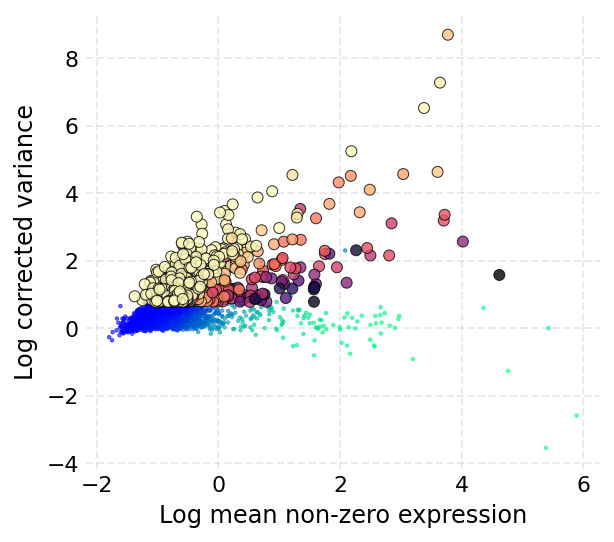

INFO: Using PCA for dimension reduction
INFO: No value provided for parameter `ann_metric`. Will use default value: l2
INFO: No value provided for parameter `ann_efc`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_ef`. Will use default value: min(100, max(k * 3, 50))
INFO: No value provided for parameter `ann_m`. Will use default value: 48
INFO: No value provided for parameter `rand_state`. Will use default value: 4466
INFO: No value provided for parameter `local_connectivity`. Will use default value: 1.0
INFO: No value provided for parameter `bandwidth`. Will use default value: 1.5
INFO: Normalizing with feature subset
[########################################] | 100% Completed |  0.4s


Writing data to normed__I__hvgs/data: 100%|██████████| 8/8 [00:00<00:00,  8.03it/s]

INFO: Calculating mean of norm. data
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.1s
INFO: Calculating std. dev. of norm. data
[########################################] | 100% Completed |  0.2s


Estimating seed partitions: 100%|██████████| 6/6 [00:00<00:00,  7.34it/s]

INFO: Saving loadings to RNA/normed__I__hvgs/reduction__pca__25__I
INFO: Saving ANN index to RNA/normed__I__hvgs/reduction__pca__25__I/ann__l2__50__50__48__4466
INFO: Saving kmeans clusters to RNA/normed__I__hvgs/reduction__pca__25__I/kmeans__100__4466



Saving KNN graph: 100%|██████████| 6/6 [00:00<00:00,  7.25it/s]

INFO: ANN recall: 99.85%



Smoothening KNN distances: 100%|██████████| 2/2 [00:00<00:00, 26.16it/s]


	completed  0  /  250 epochs
	completed  25  /  250 epochs
	completed  50  /  250 epochs
	completed  75  /  250 epochs
	completed  100  /  250 epochs
	completed  125  /  250 epochs
	completed  150  /  250 epochs
	completed  175  /  250 epochs
	completed  200  /  250 epochs
	completed  225  /  250 epochs
	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs
time: 41.5 s


In [7]:
# Interferon beta stimulated PBMC data
ds_stim = scarf_pipeline(in_dir='scarf_datasets/kang_14K_ifnb-pbmc_rnaseq')

Finding markers: 100%|██████████| 221/221 [00:22<00:00,  9.68it/s]


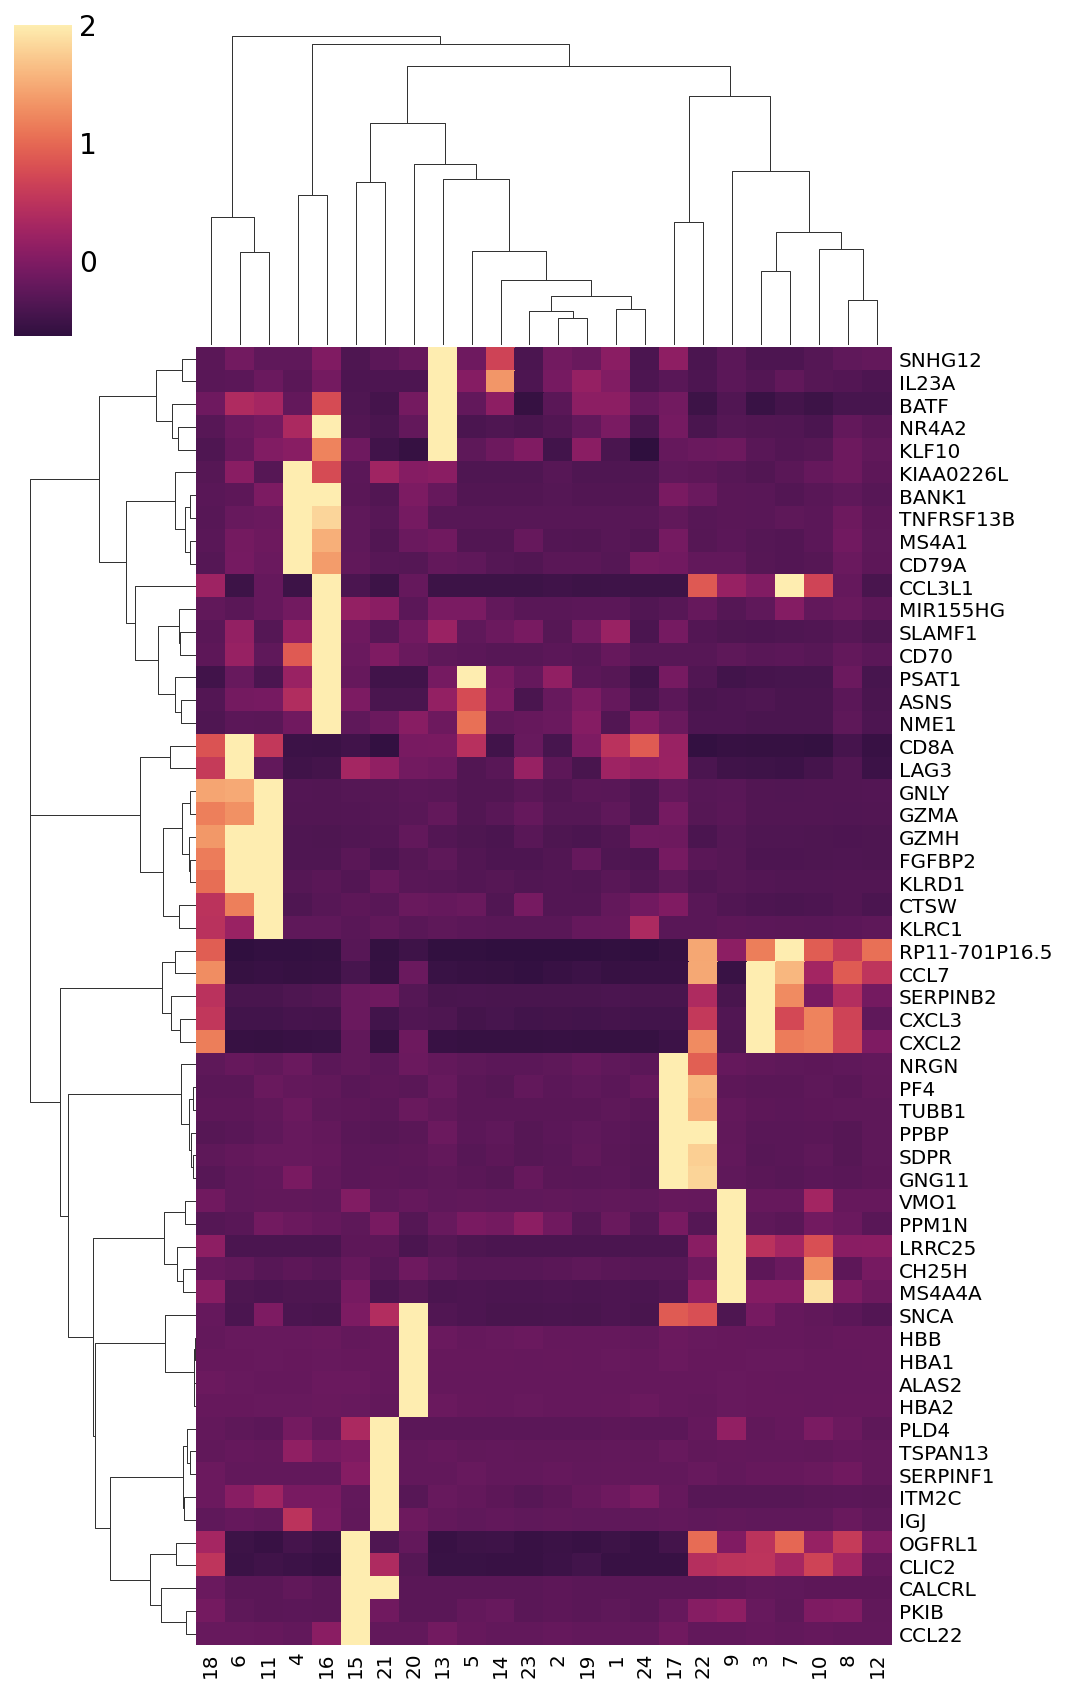

time: 25.1 s


In [8]:
ds_stim.run_marker_search(group_key='RNA_leiden_cluster')
ds_stim.plot_marker_heatmap(group_key='RNA_leiden_cluster', topn=5, figsize=(8,12))

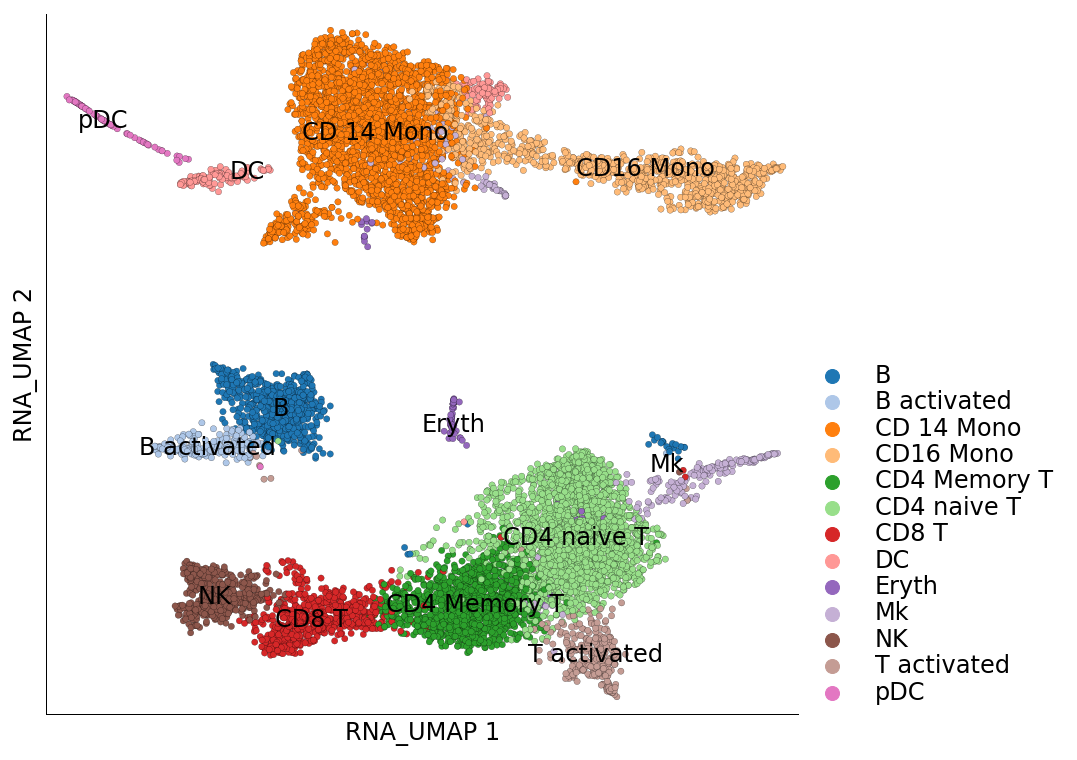

time: 566 ms


In [9]:
stim_cluster_labels = {
    24: 'CD4 naive T', 23: 'CD4 naive T', 19: 'CD4 naive T',
    5: 'CD4 naive T', 2: 'CD4 naive T', 14: 'CD4 naive T',
    1: 'CD4 Memory T', 13: 'T activated', 6: 'CD8 T', 11: 'NK',
    4: 'B', 16: 'B activated', 10: 'CD16 Mono', 9: 'CD16 Mono',
    3: 'CD 14 Mono', 7: 'CD 14 Mono', 8: 'CD 14 Mono', 12: 'CD 14 Mono',
    22: 'CD 14 Mono', 18: 'CD 14 Mono',
    15: 'DC', 21: 'pDC', 17: 'Mk', 22: 'Mk', 20: 'Eryth'
}
ds_stim.cells.insert('cluster_labels',
                     [stim_cluster_labels[x] for x in ds_stim.cells.fetch('RNA_leiden_cluster')],
                     overwrite=True)
ds_stim.plot_layout(layout_key='RNA_UMAP', color_by='cluster_labels', save_dpi=300)